In [1]:
import seaborn as sns
sns.set()

In [2]:
from static_grader import grader

# ML: Predicting Star Ratings


Our objective is to predict a new venue's popularity from information available when the venue opens.  We will do this by machine learning from a data set of venue popularities provided by Yelp.  The data set contains meta data about the venue (where it is located, the type of food served, etc.).  It also contains a star rating. Note that the venues are not limited to restaurants. This tutorial will walk you through one way to build a machine learning algorithm.


## Metrics and scoring

For most questions, you are asked to submit your models `predict` method to the grader. The grader uses a test set to evaluate your model's performance against our reference solution, using the $R^2$ score. It **is** possible to receive a score greater than one, indicating that you've beaten our reference model. We compare our model's score on a test set to your score on the same test set. See how high you can go!

## Download and parse the incoming data


We start by downloading the data set from Amazon S3:

In [3]:
!aws s3 sync s3://dataincubator-course/mldata/ . --exclude '*' --include 'yelp_train_academic_dataset_business.json.gz'

The training data are a series of JSON objects, in a Gzipped file. Python supports Gzipped files natively: [`gzip.open`](https://docs.python.org/3/library/gzip.html) has the same interface as `open`, but handles `.gz` files automatically.

The built-in `json` package has a `loads` function that converts a JSON string into a Python dictionary. We could call that once for each row of the file. [`ujson`](http://docs.micropython.org/en/latest/library/ujson.html) has the same interface as the built-in `json` package, but is *substantially* faster (at the cost of non-robust handling of malformed JSON). We will use that inside a list comprehension to get a list of dictionaries:

In [4]:
import ujson as json
import gzip

with gzip.open('yelp_train_academic_dataset_business.json.gz') as f:
    data = [json.loads(line) for line in f]

In scikit-learn, the labels to be predicted, in this case, the stars, are always kept in a separate data structure than the features. Let's get in this habit now, by creating a separate list of the ratings.

In [5]:
star_ratings = [row['stars'] for row in data]

In [6]:
data

[{'business_id': 'vcNAWiLM4dR7D2nwwJ7nCA',
  'full_address': '4840 E Indian School Rd\nSte 101\nPhoenix, AZ 85018',
  'hours': {'Tuesday': {'close': '17:00', 'open': '08:00'},
   'Friday': {'close': '17:00', 'open': '08:00'},
   'Monday': {'close': '17:00', 'open': '08:00'},
   'Wednesday': {'close': '17:00', 'open': '08:00'},
   'Thursday': {'close': '17:00', 'open': '08:00'}},
  'open': True,
  'categories': ['Doctors', 'Health & Medical'],
  'city': 'Phoenix',
  'review_count': 7,
  'name': 'Eric Goldberg, MD',
  'neighborhoods': [],
  'longitude': -111.983758,
  'state': 'AZ',
  'stars': 3.5,
  'latitude': 33.499313,
  'attributes': {'By Appointment Only': True},
  'type': 'business'},
 {'business_id': 'JwUE5GmEO-sH1FuwJgKBlQ',
  'full_address': '6162 US Highway 51\nDe Forest, WI 53532',
  'hours': {},
  'open': True,
  'categories': ['Restaurants'],
  'city': 'De Forest',
  'review_count': 26,
  'name': 'Pine Cone Restaurant',
  'neighborhoods': [],
  'longitude': -89.335844,
  's

# Questions


## Question 1: city_avg

The venues belong to different cities.  You can imagine that the ratings in some cities are probably higher than others.  We wish to build an estimator to make a prediction based on this, #### but first we need to work out the average rating for each city.  For this problem, create a list of tuples (city name, star rating), one for each city in the data set. There are many ways to do this; please feel free to experiment on your own.  If you get stuck, the steps below attempt to guide you through the process.

A simple approach is to go through all of the dictionaries in our array, calculating the sum of the star ratings and the number of venues for each city. At the end, we can just divide the stars by the count to get the average. We could create a separate sum and count variable for each city, but that will get tedious quickly. A better approach is to create a dictionary for each. The key will be the city name, and the value the running sum or running count.

One slight annoyance of this approach is that we will have to test whether a key exists in the dictionary before adding to the running tally.  The `collections` module's `defaultdict` class works around this by providing default values for keys that haven't been used. Thus, if we do

In [7]:
from collections import defaultdict

star_sum = defaultdict(int)
count = defaultdict(int)

we can increment any key of `star_sum` or `count` without first worrying whether the key exists. We need to go through the `data` and `star_ratings` list together, which we can do with the `zip` function.

In [8]:
for row, stars in zip(data, star_ratings):
    # increment the running sum in star_sum
    star_sum[row['city']]=star_sum.get(row['city'],0)+stars
    
    # increment the running count in count
    count[row['city']]=count.get(row['city'],0)+1

In [9]:
star_sum['Anthem']

208.0

Now we can calculate the average ratings.  Again, a dictionary makes a good container.

In [10]:
avg_stars = dict()
for city in star_sum:
    # calculate average star rating and store in avg_stars
    avg_stars[city]=star_sum[city]/count[city]

There should be 167 different cities:

We can get that list of tuples by converting the returned view object from the `items` method into a list.

## Question 2: city_model

Now, let's build a custom estimator that will make a prediction based solely on the city of a venue.  It is tempting to hard-code the answers from the previous section into this model, but we're going to resist and do things properly.

This custom estimator will have a `fit` method.  It will receive `data` as its argument `X` and `star_ratings` as `y`, and should repeat the calculation of the previous problem there.  Then the `predict` method can look up the average rating for the city of each record it receives.

In [11]:
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np

class CityRegressor(BaseEstimator, RegressorMixin):
    
    def __init__(self):
        self.avg_stars = dict()
    
    def fit(self, X, y):
        
        star_sum=defaultdict(int)
        count=defaultdict(int)
        
        for row,star in zip(X,y):
            star_sum[row['city']]=star_sum.get(row['city'],0)+star
            count[row['city']]=count[row['city']]+1
            
        avg_stars=defaultdict(int)
        for city in star_sum:
            avg_stars[city]=star_sum[city]/count[city]
        # Store the average rating per city in self.avg_stars
        self.avg_stars=avg_stars
        
        return self
    
    def predict(self, X):
        
        result = list()
        
        for row in X:
            if row['city'] in self.avg_stars:
                result.append(self.avg_stars[row['city']])
            else:
                result.append(sum(self.avg_stars.values())/len(self.avg_stars.values())) # replace with average if no city at training dataset
       
        return result


Now we can create an instance of our regressor and train it.

In [12]:
city_model = CityRegressor()
city_model.fit(data, star_ratings)

CityRegressor()

There is a problem, however.  What happens if we're asked to estimate the rating of a venue in a city that's not in our training set?

'Timbuktu' is not in city names, 'Madison' and 'Phoenix' are in the list of cities.

In [13]:
city_model.predict([{'city': 'Phoenix'}, {'city': 'Timbuktu'}, {'city': 'Madison'},{'city': 'Tehran'}])

[3.6702903946388683,
 3.7127593360958078,
 3.6457337883959045,
 3.7127593360958078]

In [14]:
grader.score('ml__city_avg', list(avg_stars.items()))

Your score: 1.0000


## Question 3: lat_long_model

You can imagine that a city-based model might not be sufficiently fine-grained. For example, we know that some neighborhoods are trendier than others.  Use the latitude and longitude of a venue as features that help you understand neighborhood dynamics.

Since we need to select the appropriate columns from our dictionaries to build our latitude-longitude model, we will have to use scikit-learn's [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html). However, the `ColumnTransformer` works with either NumPy arrays or pandas data frames. While we can convert our training data into a data frame easily, the test set the grader uses is a list of dictionaries. Thus, our first estimator in our workflow should be a transformer that converts a list of dictionaries into a pandas data frame.

In [15]:
import pandas as pd
from sklearn.base import TransformerMixin

class ToDataFrame(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        return self
    
    def transform(self, X):
        
        # Return a pandas data frame from X
        df=pd.DataFrame(X)
        return df

Let's test out the transformer.

In [16]:
to_data_frame = ToDataFrame()
X_t = to_data_frame.fit_transform(data[:5])

# Check that our transformer properly transform the input data into a data frame
grader.check((X_t == pd.DataFrame(data[:5])).all(axis=None))

True

In [17]:
data[:5]

[{'business_id': 'vcNAWiLM4dR7D2nwwJ7nCA',
  'full_address': '4840 E Indian School Rd\nSte 101\nPhoenix, AZ 85018',
  'hours': {'Tuesday': {'close': '17:00', 'open': '08:00'},
   'Friday': {'close': '17:00', 'open': '08:00'},
   'Monday': {'close': '17:00', 'open': '08:00'},
   'Wednesday': {'close': '17:00', 'open': '08:00'},
   'Thursday': {'close': '17:00', 'open': '08:00'}},
  'open': True,
  'categories': ['Doctors', 'Health & Medical'],
  'city': 'Phoenix',
  'review_count': 7,
  'name': 'Eric Goldberg, MD',
  'neighborhoods': [],
  'longitude': -111.983758,
  'state': 'AZ',
  'stars': 3.5,
  'latitude': 33.499313,
  'attributes': {'By Appointment Only': True},
  'type': 'business'},
 {'business_id': 'JwUE5GmEO-sH1FuwJgKBlQ',
  'full_address': '6162 US Highway 51\nDe Forest, WI 53532',
  'hours': {},
  'open': True,
  'categories': ['Restaurants'],
  'city': 'De Forest',
  'review_count': 26,
  'name': 'Pine Cone Restaurant',
  'neighborhoods': [],
  'longitude': -89.335844,
  's

In [18]:
np.array([data[0]['latitude'], data[0]['longitude']])

array([  33.499313, -111.983758])

In [19]:
result = []
for i in range(len(X_t)):
    z=np.array(X_t['latitude'][i],X_t['longitude'][i])
    result.append(z)

In [20]:
X_t.columns


Index(['business_id', 'full_address', 'hours', 'open', 'categories', 'city',
       'review_count', 'name', 'neighborhoods', 'longitude', 'state', 'stars',
       'latitude', 'attributes', 'type'],
      dtype='object')

Now we are ready to use `ColumnTransformer` and test it out.

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

class ColumnSelectTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self,X=None):
        self.X = X  # We will need these in transform()
    
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        return self
    
    def transform(self, X):
        z3=list(zip(X['latitude'],X['longitude']))
        
        #result = [[ele['latitude'], ele['longitude']] for ele in X]
        # Return an array with the same number of rows as X and one
        # column for each in self.col_names
        return z3

In [22]:
import numpy as np
from sklearn.compose import ColumnTransformer

selector = ColumnSelectTransformer()
expected = np.array([data[0]['latitude'], data[0]['longitude']])

# Check that our selector returns just two columns, the latitude and longitude
grader.check((selector.fit_transform(X_t)[0] == expected).all())

True

Now, let's feed the output of the transformer in to a `KNeighborsRegressor`. As a sanity check, we'll test it with the first 5 rows.

In [23]:
from sklearn.neighbors import KNeighborsRegressor

# Training the model
data_transform = to_data_frame.transform(data)
data_transform = selector.fit_transform(data_transform)
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(data_transform, star_ratings)

# Making predictions
test_data = data[:5]
test_data_transform = to_data_frame.transform(test_data)
test_data_transform = selector.transform(test_data_transform)
knn.predict(test_data_transform)

array([4. , 4.2, 4. , 3.8, 4.2])

In [24]:
star_ratings[:5]

[3.5, 4.0, 4.0, 4.5, 4.0]

We are not ready to submit to the grader; there are two things we still need to do:
1. Wrap all the steps necessary to go from our data (list of dictionaries) to predicted ratings
1. Determine the optimal value for our predictor's hyperparameter

For the first point, we will use a pipeline, ensuring that our model applies all the required transformations given the form of the input data. Remember that a pipeline is made with a list of `(step_name, estimator)` tuples.

In [25]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('dataframe',ToDataFrame()),
    ('transform',ColumnSelectTransformer()) ,
    ('KNN',KNeighborsRegressor(n_neighbors=5)) ,
])

Now let's fit and predict.

In [26]:
pipe.fit(data, star_ratings)
pipe.predict(data[:5])

array([4. , 4.2, 4. , 3.8, 4.2])

In [27]:
star_ratings[:5]

[3.5, 4.0, 4.0, 4.5, 4.0]

Let's now focus on the second point. The `KNeighborsRegressor` takes the `n_neighbors` hyperparameter, which tells it how many nearest neighbors to average together when making a prediction. There is no reason to believe that 5 is the optimum value. We will need to determine a better value for this hyperparameter. A common approach is to use a hyperparameter searching tool such as [`GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV). You may need to refer back to the notebooks about the ways to interface searching tools and pipelines.

You should consider whether the data needs to be shuffled as it might not have been randomized. For example, the data could be ordered by a certain feature or by the labels. If you perform a train/test split with [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split), the data is shuffled by default. However, when using `GridSearchCV`, the folds are not shuffled when you use the default K-folds cross-validation.

The code below will plot a rolling mean of the star ratings. Do you need to shuffle the data?

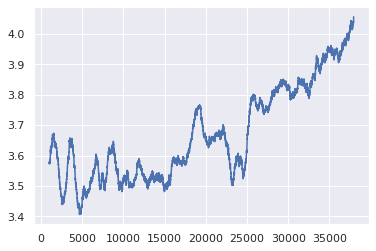

In [28]:
from pandas import Series
import matplotlib.pyplot as plt

plt.plot(Series.rolling(Series(star_ratings), window=1000).mean());

Once you've found a good value of `n_neighbors`, submit the model to the grader. Note, "good" is a relative measure here. The reference solution has an $R^2$ score of only 0.02. There is just rather little signal available for modeling.

# Optimize the Kneighbours

In [29]:
X=data
y=star_ratings

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [31]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('dataframe',ToDataFrame()),
    ('transform',ColumnSelectTransformer()) ,
    ('KNN',KNeighborsRegressor()) ,
])

In [32]:
from sklearn.model_selection import GridSearchCV
lat_long_model= GridSearchCV(
    pipe,
    {'KNN__n_neighbors': list(range(80,150,10))},
    cv=10,  
    n_jobs=2
    )
lat_long_model.fit(data, star_ratings)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('dataframe', ToDataFrame()),
                                       ('transform', ColumnSelectTransformer()),
                                       ('KNN', KNeighborsRegressor())]),
             n_jobs=2,
             param_grid={'KNN__n_neighbors': [80, 90, 100, 110, 120, 130, 140]})

In [33]:
grader.score('ml__lat_long_model',  lat_long_model.predict)  # Edit to appropriate name

Your score: 0.9975


### Evaluate Model Performance

## Question 4: category_model

While location is important, we could also try seeing how predictive the
venue's category is. Build an estimator that considers only the `'categories'` field of the data.

The categories come as a list of strings, but the scikit-learn's predictors all need numeric input. We ultimately want to create a column in our feature matrix to represent every category. For a given row, only the columns that represent the categories it contains will be filled with a one, otherwise, it will be filled with a zero. The described method is similar to **one-hot encoding**, however, an observation/row can contain more than one "hot", non-zero, column.

To achieve our encoding plan, we need to use scikit-learn's provides [`DictVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html#sklearn.feature_extraction.DictVectorizer). This transformer takes a 1-D array of dictionaries and creates a column in the output matrix for each key in the dictionary and fills it with the value associated with it. Missing keys are filled with zeros. However, we need to build a transformer that takes an array of strings and returns an array of dictionaries with keys given by those strings and values of one. For example, it should transform `X_in` into `X_out`.

In [34]:
X_in = pd.Series([['a'], ['b', 'c']])
X_out = pd.Series([{'a': 1}, {'b': 1, 'c': 1}])

print(X_in)
print(X_out)

0       [a]
1    [b, c]
dtype: object
0            {'a': 1}
1    {'b': 1, 'c': 1}
dtype: object


In [35]:
class DictEncoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # X will be a pandas series. Return a pandas series of dictionaries
        d=[]
        for i in X:
            b={}
            for item in i:
                b[item]=i.count(item)
            d.append(b)
        return d

In [36]:
class ColumnSelectTransformer_categ(BaseEstimator, TransformerMixin):
    
    def __init__(self, col_names):
        self.col_names = col_names  # We will need these in transform()
    
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        return self
    
    def transform(self, X):
        result = []
        for ele in X:
            result.extend([ele[i] for i in self.col_names ])
        
        # Return an array with the same number of rows as X and one
        # column for each in self.col_names
        return result


In [37]:
cst = ColumnSelectTransformer_categ(['categories'])
z=cst.fit_transform(data)


Now, create a pipeline object of the two step transformation for the categories data. Afterwards, create a `ColumnTransformer` object that will use the aforementioned pipeline object to transform the `'categories'` field.

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Ridge

pipe_cat=Pipeline([('transformer',ColumnSelectTransformer_categ(['categories'])),
               ('dict', DictEncoder()),
                ('vec',DictVectorizer(sparse=False)),
                #('tf_idf',sklearn.feature_extraction.text.TfidfTransformer())
                ('estimator', Ridge())])

In [39]:
#pipe_cat.get_params()

Finally, create a pipeline object that will
1. Convert our list of dictionaries into a data frame
1. Select the `'categories'` column and encode the data
1. Train a regularized linear model such as `Ridge`

There will be a large number of features, one for each category, so there is a significant danger of overfitting. Use cross validation to choose the best regularization parameter.

In [40]:
from sklearn.model_selection import GridSearchCV

category_model= GridSearchCV(
    pipe_cat,
    {"estimator__alpha": [1.e-2, 1.e-1, 1.e0, 1.e+1, 1.e+2, 1.e+3]}, # range of hyperparameters to test
    cv=10,  # 10-fold cross validation
    n_jobs=2,  # run each hyperparameter in one of two parallel jobs
    )
category_model.fit(data, star_ratings)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnSelectTransformer_categ(col_names=['categories'])),
                                       ('dict', DictEncoder()),
                                       ('vec', DictVectorizer(sparse=False)),
                                       ('estimator', Ridge())]),
             n_jobs=2,
             param_grid={'estimator__alpha': [0.01, 0.1, 1.0, 10.0, 100.0,
                                              1000.0]})

In [41]:
category_model.best_params_

{'estimator__alpha': 10.0}

In [42]:
grader.score('ml__category_model', category_model.predict)  # Edit to appropriate name

Your score: 1.0055


### Evaluate Model Performance

**Extension:** Some categories (e.g., Restaurants) are not very specific. Others (Japanese sushi) are much more so.  One way to deal with this is with an measure call term frequency-inverse document frequency (tf-idf). Add in a [`TfidfTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) between the `DictVectorizer` and the linear model, and see if that improves performance.

## Question 5: attribute_model

There is even more information in the attributes for each venue.  Let's build an estimator based on these.

Venues attributes may be nested:
```python
{
  'Attire': 'casual',
  'Accepts Credit Cards': True,
  'Ambiance': {'casual': False, 'classy': False}
}
```
We wish to encode them in the same manner as our categories data using the `DictVectorizer`. Before we do so, we need to flatten the dictionary to a single level:
```python
{
  'Attire_casual' : 1,
  'Accepts Credit Cards': 1,
  'Ambiance_casual': 0,
  'Ambiance_classy': 0
}
```
Build a custom transformer that flattens the dictionary for the `'attributes'` field. Similar to what was done before, create a model that properly encodes the attribute data and learns to predict the ratings.

You may find it difficult to find a single regressor that does well enough. A common solution is to use a linear model to fit the linear part of some data, and use a non-linear model to fit the residual that the linear model can't fit. Build a custom predictor that takes as an argument two other predictors. It should use the first to fit the raw data and the second to fit the residuals of the first.

In [43]:
!pip install flatten-dict
from flatten_dict.reducers import make_reducer
from flatten_dict import flatten

def flatendict(list_of_dictionaries):
    lst=[]
    for i in range(len(list_of_dictionaries)):
        d=flatten(list_of_dictionaries[i], reducer=make_reducer(delimiter='_'))
        lst.append(d)
    return lst


  Using cached flatten_dict-0.4.2-py2.py3-none-any.whl (9.7 kB)


In [44]:
#MAKE A FunctionTransformer from function flatendict to use in pipeline
from sklearn.preprocessing import FunctionTransformer

flatendict_transformer = FunctionTransformer(flatendict)

In [45]:
# Create the transformer to handle the attributes data

# Create the linear + non-linear ensemble predictor

# Create the attribute model

In [46]:
pipe_att = Pipeline([
    ('cst', ColumnSelectTransformer_categ(['attributes'])),
    ('flatendict', flatendict_transformer),
    ('vec',DictVectorizer(sparse=False)),
    ('estimator', Ridge())
    ])

In [47]:
attribute_est= GridSearchCV(
    pipe_att,
    {"estimator__alpha": [1.e-4, 1.e-3, 1.e-2, 1.e-1, 1.e0, 1.e+1, 1.e+2]},  # range of hyperparameters to test
    cv=10,  # 10-fold cross validation
    n_jobs=2,  # run each hyperparameter in one of two parallel jobs
)
attribute_est.fit(data, star_ratings)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('cst',
                                        ColumnSelectTransformer_categ(col_names=['attributes'])),
                                       ('flatendict',
                                        FunctionTransformer(func=<function flatendict at 0x7f04c667bb80>)),
                                       ('vec', DictVectorizer(sparse=False)),
                                       ('estimator', Ridge())]),
             n_jobs=2,
             param_grid={'estimator__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0,
                                              10.0, 100.0]})

In [48]:
attribute_est.best_params_

{'estimator__alpha': 10.0}

In [49]:
class Residual_Predictor(BaseEstimator, TransformerMixin, RegressorMixin):
    
    def __init__(self):

        self.base = Ridge(alpha=0.1)
        self.residual = RandomForestRegressor(max_depth = 10, n_estimators = 150)
        
    def fit(self, X, y=None):
        self.base = self.base.fit(X, y)
        self.residual = self.residual.fit(X, np.array(y) - np.array(self.base.predict(X)))
        return self
    
    def predict(self, X):
        return np.array(self.base.predict(X))+np.array(self.residual.predict(X))

In [50]:
from sklearn.ensemble import RandomForestRegressor

attribute_model = Pipeline([
    ('cst', ColumnSelectTransformer_categ(['attributes'])),
    ('flatendict', flatendict_transformer),
    ('vec',DictVectorizer(sparse=False)),
    #('tf_idf',sklearn.feature_extraction.text.TfidfTransformer())
    ('estimator', Residual_Predictor())
    ])

attribute_model.fit(data, star_ratings)

Pipeline(steps=[('cst',
                 ColumnSelectTransformer_categ(col_names=['attributes'])),
                ('flatendict',
                 FunctionTransformer(func=<function flatendict at 0x7f04c667bb80>)),
                ('vec', DictVectorizer(sparse=False)),
                ('estimator', Residual_Predictor())])

In [51]:
grader.score('ml__attribute_model', attribute_model.predict)  # Edit to appropriate name

Your score: 1.0069


### Evaluate Model Performance

## Question 6: full_model

So far we have only built models based on individual features.  Now we will build an ensemble regressor that averages together the estimates of the four previous regressors.

In order to use the existing models as input to a predictor, we will have to turn them into transformers; a predictor can only be in the final step of a pipeline. Build a custom `ModelTransformer` class that takes a predictor as an argument. When `fit` is called, the predictor should be fit. When `transform` is called, the predictor's `predict` method should be called, and its results returned as the transformation.

Note that the output of the `transform` method should be a 2-D array with a single column in order for it to work well with the scikit-learn pipeline. If you're using NumPy arrays, you can use `.reshape(-1, 1)` to create a column vector. If you are just using Python lists, you will want a list of lists of single elements.

In [52]:
class ModelTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, model):
        # What needs to be done here?
        self.model = model
    
    def fit(self, X, y):
        # Fit the stored predictor.
        # Question: what should be returned?
        return self
    
    def transform(self, X):
        # Use predict on the stored predictor as a "transformation".
        # Be sure to return a 2-D array.
        arr = self.model.predict(X)
        return [[item] for item in arr]
    
    

Let's now test it out on our `city_model`.

In [53]:
city_trans = ModelTransformer(city_model)
city_trans.fit(data, star_ratings)
X_t = city_trans.transform(data[:5])

# Check that the transformation output is a 2-D array with one column
grader.check(np.array(X_t).shape[-1] == 1)

True

In [54]:
y_pred = np.array(city_model.predict(data[:5]))

# Check that the transformation output is the same as the model's predictions
grader.check((y_pred.reshape(-1, 1) == X_t).all())

True

Create an instance of `ModelTransformer` for each of the previous four models. Combine these together in a single feature matrix with a
[`FeatureUnion`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html#sklearn.pipeline.FeatureUnion).

In [55]:
from sklearn.pipeline import FeatureUnion


union = FeatureUnion([
        # FeatureUnion uses the same syntax as Pipeline
    ('city_trans',ModelTransformer(city_model)),
    ('latlon_trans', ModelTransformer( lat_long_model)),
    ('cat_trans', ModelTransformer(category_model)),
    ('att_trans', ModelTransformer(attribute_model)) 
    ])

Our `FeatureUnion` object should return a feature matrix with four columns.

In [56]:
union.fit(data, star_ratings)
X_t = union.transform(data[:5])

# Transformed data should have 5 rows and 4 columns
grader.check(X_t.shape == (5, 4))

True

Finally, use a pipeline to combine the feature union with a linear regression (or another model) to weight the predictions.

In [57]:
from sklearn.ensemble import RandomForestRegressor

full_model = Pipeline([
    ('union', FeatureUnion([
                            ('city_trans',ModelTransformer(city_model)),
                            ('latlon_trans', ModelTransformer( lat_long_model)),
                            ('cat_trans', ModelTransformer(category_model)),
                            ('att_trans', ModelTransformer(attribute_model))
                            ])),
    ('estimator', RandomForestRegressor())
    ])


    


In [58]:
full_model.estimator.get_params().keys()

AttributeError: 'Pipeline' object has no attribute 'estimator'

In [59]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 50, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]



In [60]:
param_grid = {'estimator__n_estimators': n_estimators,
               'estimator__max_features': max_features,
               'estimator__max_depth': max_depth,
               }

In [61]:
full_model_est= GridSearchCV(
    full_model,
    param_grid,  # range of hyperparameters to test
    cv=10,  # 10-fold cross validation
    n_jobs=2,  # run each hyperparameter in one of two parallel jobs
)


In [62]:
full_model_est.fit(data, star_ratings)

/opt/conda/envs/data3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
2400 fits failed out of a total of 2400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2400 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/envs/data3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/envs/data3/lib/python3.9/site-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/envs/data3/lib/python3.9/site-packages/sklearn/pipeline.py", line 348, in _fit
    X, fitted_transformer = fit_transform_one_cach

ZeroDivisionError: division by zero

In [ ]:
full_model.fit(data, star_ratings)

In [ ]:
grader.score('ml__full_model', full_model.predict)  # Edit to appropriate name

### Evaluate Model Performance

**Extension:** Try a non-linear model such as [`RandomForestRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor) to blend the predictions of the four models. Are you able to get better results? If so, what do you think it's learning how to do?

*Copyright &copy; 2021 Pragmatic Institute. This content is licensed solely for personal use. Redistribution or publication of this material is strictly prohibited.*